<a href="https://colab.research.google.com/github/RodolfoFigueroa/madi2022-1/blob/main/Unidad_4/01_Ordenamiento_topologico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
from queue import deque

En esta libreta, veremos un recordatorio de ordenamiento topológico, y cómo puede aplicarse para resolver distintos problemas.

# Definición

Copiando lo que habíamos escrito en la libreta `6_NetworkX_para_graficas_planares_y_dirigidas` (Unidad 1), tenemos que un ordenamiento topológico de los vértices de una gráfica dirigida cumple que, si existe una arista del vértice $u$ al vértice $v$, entonces $u$ viene antes de $v$ en el ordenamiento.

Por ejemplo, tomando la siguiente gráfica:

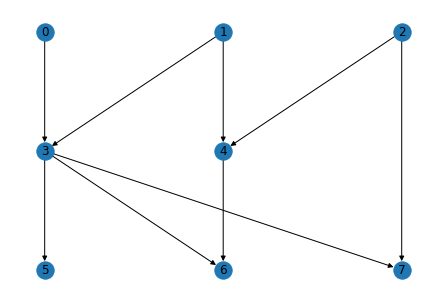

In [60]:
g = nx.DiGraph()
g.add_nodes_from([0,1,2,3,4,5,6,7])
g.add_edges_from([(0,3), (1,3), (1,4), (2,4), (2,7), (3,5), (3,6), (3,7), (4,6)])
pos = {i: (i%3, 3-i//3*3) for i in g.nodes}
pos[5], pos[6], pos[7] = [0,-3], [1,-3], [2,-3]
nx.draw(g, with_labels=True, pos=pos)

Algunos ordenamientos posibles son:

* 0, 1, 2, 3, 4, 5, 6, 7
* 2, 0, 1, 4, 3, 5, 6, 7
* 0, 1, 2, 4, 3, 7, 6, 5

Una manera sencilla de comprobar si un ordenamiento es válido es colocar a todos los vértices en una fila, siguiendo el ordenamiento de izquierda a derecha. Si todas las aristas apuntan hacia la derecha, entonces es válido.

# Algoritmos

## Post-order

En la libreta previamente mencionada, probamos que una manera de generar un ordenamiento topológico es la de recorrer la gráfica en reverse postorder, lo cual se ve reflejado en la siguiente función:

In [61]:
def _order_handler(g, v, kind, visited=None, out=None): 
    visited[v] = True
    if kind == 'preorder':
        out.append(v)
    for u in g.adj[v]:
        if not visited[u]:
            _order_handler(g, u, kind, visited, out) # recursion
    if kind != 'preorder': # postorder or reverse_postorder
        out.append(v)


def order(g, kind):
    visited = [False] * len(g.nodes)
    out = []
    for n in g.nodes:
        if not visited[n]:
            _order_handler(g, n, kind, visited, out)
            
    if kind == 'reverse_postorder':
        return out[::-1]
    else:
        return out

Aplicándola a nuestra gráfica anterior:

In [62]:
res = order(g, 'reverse_postorder')
res

[2, 1, 4, 0, 3, 7, 6, 5]

Podemos comprobar a ojo que es un ordenamiento correcto:

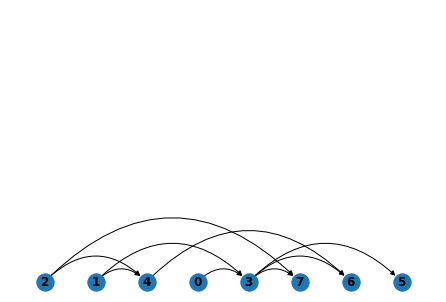

In [63]:
def pos_order(order):
    pos = {}
    for i, p in enumerate(order):
        pos[p] = (i,0)
    return pos

pos = pos_order(res)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

Claramente, todas las aristas apuntan en la misma dirección.

## Kahn

Otra manera de generar un ordenamiento es utilizando el algoritmo de Kahn. Este puede expresarse en pseudocódigo como:

* $S$: Conjunto de vértices sin ninguna arista entrante. Al inicio es no-vacío (de otra manera la gráfica no tiene un ordenamiento topológico válido).
* $L$: Lista que contendrá los vértices en orden topológico.
1. Mientras $S$ no es vacío:
    1. Tomamos un vértice $n$ de $S$.
    2. Añadimos $n$ a $L$.
    3. Para cada vértice $m$ con arista $e$ de $n$ a $m$:
        1. Removemos a $e$ de la gráfica
        2. Si $m$ no tiene más aristas entrantes, lo insertamos en $S$.

Si al final de la ejecución, la gráfica sigue teniendo aristas, significa que tenía un ciclo, y por lo tanto no tiene un ordenamiento. De otra manera, $L$ será un ordenamiento válido.

Expresado en código, el algoritmo es:

In [68]:
def kahn_order(g):
    g = g.copy()
    S = deque()
    L = []
    for n in g.nodes:
        if g.in_degree(n) == 0:
            S.append(n)
            
    while S:
        n = S.pop()
        L.append(n)
        neighbors = list(g.neighbors(n)) 
        for m in neighbors:
            g.remove_edge(n, m)
            if g.in_degree(m) == 0:
                S.append(m)
    
    assert len(g.edges) == 0, "La gráfica tiene un ciclo."
    
    return L

Aplicándolo a nuestra gráfica:

In [69]:
res = kahn_order(g)
res

[2, 1, 4, 0, 3, 7, 6, 5]

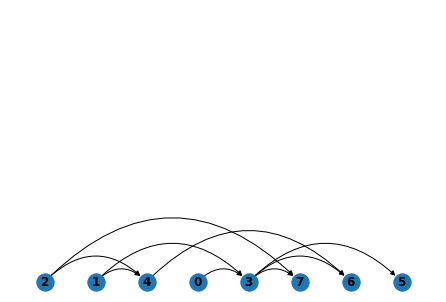

In [72]:
pos = pos_order(res)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

Veamos qué pasa con una gráfica que tiene ciclos:

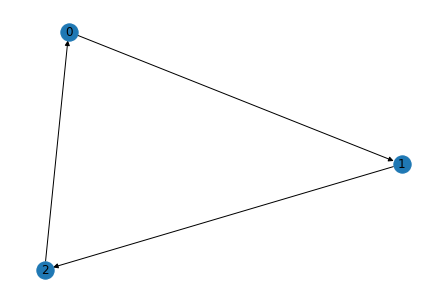

In [70]:
g_ciclo = nx.DiGraph()
g_ciclo.add_edges_from([(0, 1), (1,2), (2,0)])
nx.draw(g_ciclo, with_labels=True)

In [71]:
kahn_order(g_ciclo)

AssertionError: La gráfica tiene un ciclo.

Graficando:

# Camino más corto

Una aplicación del ordenamiento topológico es encontrar el camino más corto entre un nodo $s$ y todos los demás en una gráfica con pesos. Para hacerlo, seguimos el siguiente algoritmo:

* $d$: Lista con las distancias mínimas de cada vértice a $s$. Al inicio, $d[v]=\infty$ para toda $v\neq s$, y $d[s] = 0$.
* $p$: $p[u]$ será el predecesor de $u$ en el camino más corto de $v$ a $u$. Al inicio todas sus entradas son vacías.

1. Para cada $u$ en el ordenamiento topológico de la gráfica, empezando de $s$:
    1. Para cada vértice $v$ tal que existe una arista $(u,v)$:
        1. $w\leftarrow \text{peso}(u,v)$
        2. Si $d[v] > d[u] + w$:
            1. $d[v] \leftarrow d[u] + w$
            2. $p[v] \leftarrow u$
        
Este algoritmo solo funciona si revisamos los vértices $u$ en orden topológico, ya que de esta manera vamos actualizando las distancias de manera ordenada.

Por ejemplo, para la siguiente gráfica:

{(0, 1): Text(0.654508476093664, 0.47552828417802706, '1'),
 (0, 2): Text(0.09549147175227024, 0.2938926307527015, '5'),
 (1, 2): Text(-0.25000005215406573, 0.7694209149307285, '3'),
 (1, 3): Text(-0.25000002235174246, 0.18163562362300228, '2'),
 (1, 4): Text(0.3090170266931363, 2.980232327587373e-08, '10'),
 (3, 4): Text(-0.24999994784593424, -0.7694209149307285, '2')}

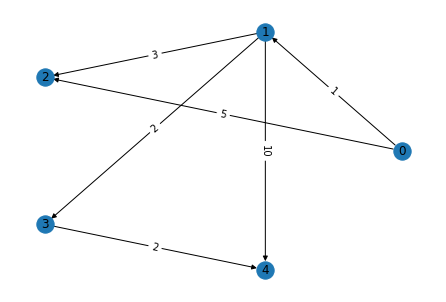

In [74]:
g = nx.DiGraph()
g.add_nodes_from(range(5))
g.add_edges_from([
    (0, 1, {'weight': 1}), 
    (1, 2, {'weight': 3}), 
    (3, 4, {'weight': 2}), 
    (1, 3, {'weight': 2}), 
    (0, 2, {'weight': 5}), 
    (1, 4, {'weight': 10})
])
pos = nx.circular_layout(g)
nx.draw(g, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

In [77]:
def shortest_paths(g, s):
    d = [float('inf')] * len(g.nodes)
    d[s] = 0
    p = [None] * len(g.nodes)
    
    order = kahn_order(g)
    idx = order.index(s)
    for u in order[idx:]:
        for v in g.neighbors(u):
            w = g.edges[(u,v)]['weight']
            if d[v] > d[u] + w:
                d[v] = d[u] + w
                p[v] = u
    return p, d
                
p, d = shortest_paths(g, 0)
print(f"Predecesores: {p}")
print(f"Distancias: {d}")

Predecesores: [None, 0, 1, 1, 3]
Distancias: [0, 1, 4, 3, 5]


# Ejercicios

Para los siguientes problemas, solo puedes usar funciones básicas de `networkx` (`nodes`, `edges`, `neighbors`, `degree`, etc.) No puedes utilizar nada relacionado a ordenamientos topológicos/DFS/BFS.

## Ejercicio 1

Escribe una función que genere todos los ordenamientos topológicos posibles de una gráfica. Compara tu resultado con lo obtenido con `nx.all_topological_sorts`.

*Aquí va la explicación de tu algoritmo*

In [10]:
# Aquí va tu código

## Ejercicio 2

Encontraste una página del diccionario de una civilización perdida. Los habitantes utilizaban el alfabeto para escribir, pero no necesariamente en el mismo orden; por ejemplo, `b` podía venir antes de `a`. 

Basándote en el hecho de que las palabras del diccionario están ordenadas lexicográficamente, y asumiendo que solo utilizaban las letras provistas, determina el orden del alfabeto.

Como ejemplo, tomamos la lista ordenada `L=["zxx","xxx","xxy"]`. Vemos que la primera palabra empieza con `z`, mientras que las otras dos empiezan con `x`. Por lo tanto, la primera letra del alfabeto es `z`. Por otro lado, las últimas dos palabras empiezan con `xx`, pero la segunda tiene una `x`, y la tercera una `y`. Por lo tanto, `x` viene antes de `y` en el alfabeto.

De esta manera, concluimos que el alfabeto es `zxy`.

*Hint:* Si representas las letras como vértices de una gráfica, de modo que una arista entre `X` y `Y` indica que `X` viene antes que `Y`, lo único que tienes que hacer es encontrar un ordenamiento topológico. Piensa entonces cómo traducir las palabras que te dan a dicha gráfica.

*Aquí va la explicación de tu algoritmo*

In [11]:
# Aquí va tu código
def dictionary_sort(L):
    None

Prueba tu código con la siguiente celda:

In [18]:
L = ["zxy", "zxw","vx","vyy","xwyy"]
res = dictionary_sort(L)
print(f"Ordenamiento esperado: [z, v, x, y, w]. Obtenido: {res}")

L = ["xyy","yxzw","yxzy","zyx","zyw"]
res = dictionary_sort(L)
print(f"Ordenamiento esperado: [x, w, y, z]. Obtenido: {res}")

Ordenamiento esperado: [z, v, x, y, w]. Obtenido: None
Ordenamiento esperado: [x, w, y, z]. Obtenido: None
